In [6]:
# ! pip uninstall tensorflow
# ! pip install tensorflow-cpu


In [1]:
#  STEP 1: Install dependencies
# ! pip install rasterio tensorflow scikit-learn tqdm

#  STEP 2: Imports
import os
import numpy as np
import rasterio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt

#  STEP 3: Load all ndwi GeoTIFFs into a 3D array

folder = "..\BTP\GEE-Exports-to_predict_July_2022"
#folder = "..\BTP\GEE-Exports-to_predict_Jan_2023"
#folder = "..\BTP\GEE-Exports-to_predict_July_2023\GEE-Exports"
#folder = "..\BTP\GEE-Exports-to_predict_Jan_2024"
#folder = "..\BTP\GEE-Exports-to_predict_July_2024"
#folder = "..\BTP\GEE-Exports-to_predict_Jan_2025"
files = sorted([f for f in os.listdir(folder) if f.endswith('.tif')])
print(files)

# print(files)
# exit()

ndwi_stack = []

print("Reading NDWI images...")
# for f in tqdm(files):
#     with rasterio.open(os.path.join(folder, f)) as src:
#         ndwi_read = src.read(1)  # Reads the first band (common for ndwi)
#         profile = src.profile
#         print(ndwi_read, "\n\n\n\n\n")
#         ndwi_stack.append(ndwi_read)

# # print(ndwi_stack)
# ndwi_stack = np.array(ndwi_stack)  # Shape: [time, height, width]
# time, height, width = ndwi_stack.shape

# print(f"Loaded ndwi stack with shape: {ndwi_stack.shape}")

# for f in files:
#     with rasterio.open(os.path.join(folder, f)) as src:
#         data = src.read(1).astype('float32')
#         nan_count = np.isnan(data).sum()
#         valid_count = np.count_nonzero(~np.isnan(data))

#         unique = np.unique(data)

#         print(np.nanmin(unique))
#         print(np.nanmax(unique))

#         print("NaN values:", nan_count)
#         print("Valid (non-NaN) values:", valid_count)
#         print(src.nodata)
#         ref_mask = np.isnan(data)
#         break

# for f in files[1:]:
#     with rasterio.open(os.path.join(folder, f)) as src:
#         data = src.read(1).astype('float32')
#         nan_count = np.isnan(data).sum()
#         valid_count = np.count_nonzero(~np.isnan(data))

#         unique = np.unique(data)

#         print(np.nanmin(unique))
#         print(np.nanmax(unique))

#         print("NaN values:", nan_count)
#         print("Valid (non-NaN) values:", valid_count)
#         print(src.nodata)
#         current_mask = np.isnan(data)
#         if not np.array_equal(ref_mask, current_mask):
#             print(f"Inconsistent NaN positions in file: {f}")
#             consistent = False
#             break


for f in files:
    with rasterio.open(os.path.join(folder, f)) as src:
        data = src.read(1).astype('float32')
        ndwi_stack.append(data)

print(type(ndwi_stack[0]))
ndwi_stack = np.array(ndwi_stack)  # Shape: [time, height, width]
time, height, width = ndwi_stack.shape

print(f"Loaded NDWI stack with shape: {ndwi_stack.shape}")

print("NDWI shape:", ndwi_stack.shape)
print("NDWI stats:", np.nanmin(ndwi_stack), np.nanmax(ndwi_stack))


<>:16: SyntaxWarning: invalid escape sequence '\B'
<>:16: SyntaxWarning: invalid escape sequence '\B'
C:\Users\DELL\AppData\Local\Temp\ipykernel_5208\123879185.py:16: SyntaxWarning: invalid escape sequence '\B'
  folder = "..\BTP\GEE-Exports-to_predict_July_2022"


['ndwi_2022_01.tif', 'ndwi_2022_02.tif', 'ndwi_2022_03.tif', 'ndwi_2022_04.tif', 'ndwi_2022_05.tif', 'ndwi_2022_06.tif']
Reading NDWI images...
<class 'numpy.ndarray'>
Loaded NDWI stack with shape: (6, 5308, 5811)
NDWI shape: (6, 5308, 5811)
NDWI stats: -0.7031583 0.24254562


In [2]:
ndwi_stack

for i, layer in enumerate(ndwi_stack):
    nans = np.isnan(layer).sum()
    print(f"Time step {i}: {nans} NaN values")

total_nans = np.isnan(ndwi_stack).sum()
print("Total NaN values in ndwi stack:", total_nans)

total_pixels = np.prod(ndwi_stack.shape)
nan_percentage = (total_nans / total_pixels) * 100
print(f"Percentage of NaN values: {nan_percentage:.2f}%")



Time step 0: 21023606 NaN values
Time step 1: 21023606 NaN values
Time step 2: 21023606 NaN values
Time step 3: 21023606 NaN values
Time step 4: 21023606 NaN values
Time step 5: 21023606 NaN values
Total NaN values in ndwi stack: 126141636
Percentage of NaN values: 68.16%


(6, 5308, 5811)
Pixels that are NaN in ALL timesteps: 21023606


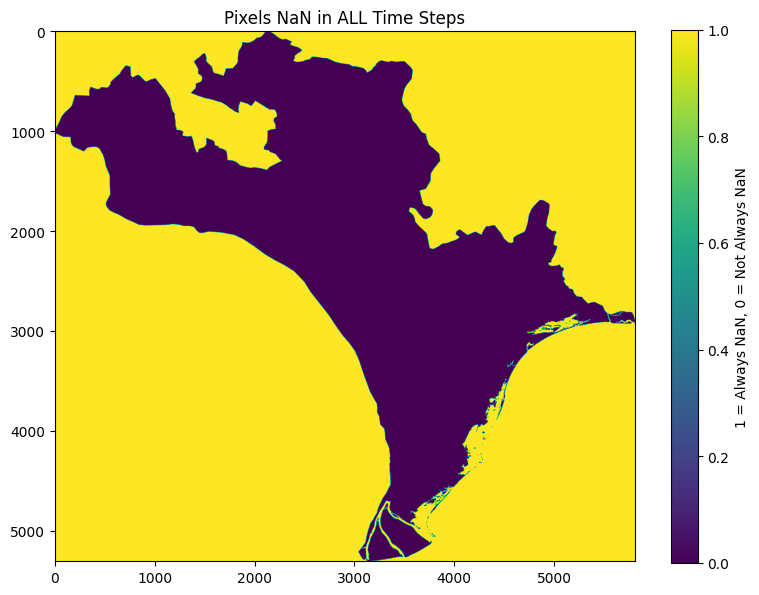

In [3]:
nan_masks = np.isnan(ndwi_stack)  # (time, height, width)
print(nan_masks.shape)

# --- Check where all time steps are NaN ---
consistent_nan_mask = np.all(nan_masks, axis=0)  # (height, width)
consistent_nan_count = np.sum(consistent_nan_mask)
print("Pixels that are NaN in ALL timesteps:", consistent_nan_count)

# --- Optional: visualize consistent NaN locations ---
plt.figure(figsize=(8, 6))
plt.imshow(consistent_nan_mask, cmap='viridis')
plt.title("Pixels NaN in ALL Time Steps")
plt.colorbar(label="1 = Always NaN, 0 = Not Always NaN")
plt.tight_layout()
plt.show()

In [4]:
ndwi_scaled = np.empty_like(ndwi_stack, dtype=np.float32)
mins = np.full((height, width), np.nan, dtype=np.float32)
maxs = np.full((height, width), np.nan, dtype=np.float32)

print("Normalizing pixels with NumPy...")
for i in tqdm(range(height)):
    for j in range(width):
        series = ndwi_stack[:, i, j]
        if np.isnan(series).any() or np.all(series == 0):
            ndwi_scaled[:, i, j] = np.nan
            continue
        min_val = np.nanmin(series)
        max_val = np.nanmax(series)
        if max_val - min_val == 0:
            ndwi_scaled[:, i, j] = np.nan
        else:
            ndwi_scaled[:, i, j] = (series - min_val) / (max_val - min_val)
            mins[i, j] = min_val
            maxs[i, j] = max_val


Normalizing pixels with NumPy...


100%|██████████| 5308/5308 [05:42<00:00, 15.49it/s]


In [5]:
import os
import numpy as np
import rasterio
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt



normalized=True
seq_length = 5  # Use 5 months to predict the 6th
X_all = []
y_all = []
coords_all = []
# valid_mask = np.ones((height, width), dtype=bool)
# for t in range(time):
#     valid_mask = valid_mask & ~np.isnan(ndwi_scaled[t])
print("Preparing training data...")
for i in tqdm(range(height)):
    for j in range(width):
        # if not valid_mask[i, j]:
        #     continue
        if normalized:
            series=ndwi_scaled[:, i, j]
        else:
            series = ndwi_stack[:, i, j]
        if np.isnan(series).any():
            continue
            
        # Use first 5 months to predict the 6th month
        X_all.append(series[:seq_length])
        y_all.append(series[seq_length])
        coords_all.append([i, j])

# Convert to numpy arrays and reshape for LSTM
X_all = np.array(X_all).reshape(-1, seq_length, 1)
y_all = np.array(y_all)
coords_all = np.array(coords_all)

print(f"Training data prepared: X shape: {X_all.shape}, y shape: {y_all.shape}")


Preparing training data...


100%|██████████| 5308/5308 [01:34<00:00, 56.30it/s]


Training data prepared: X shape: (9821182, 5, 1), y shape: (9821182,)


In [6]:

def create_lstm_model(seq_length):
    pixel_input = Input(shape=(seq_length, 1))  # ndwi time series input
    coord_input = Input(shape=(2,))  # Pixel coordinates (i, j)
    
    # LSTM layers
    # lstm_1 = LSTM(50, return_sequences=True)(pixel_input)
    lstm_1 = LSTM(32, return_sequences=True)(pixel_input)
    lstm_2 = LSTM(50)(lstm_1)
    
    # Concatenate LSTM output with coordinates for spatial awareness
    concat = Concatenate()([lstm_2, coord_input])
    
    # Output layer
    output = Dense(1)(concat)
    
    # Define the model
    model = tf.keras.Model(inputs=[pixel_input, coord_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    
    return model

print("Training LSTM model...")
model = create_lstm_model(seq_length)
model.fit(
    [X_all,coords_all], 
    y_all,
    validation_split = 0.2,
    epochs=5, 
    batch_size=2048, 
    verbose=1
)
model_path = "ndwi_lstm_model_normalized.keras"
model.save(model_path)

Training LSTM model...
Epoch 1/5
3837/3837 ━━━━━━━━━━━━━━━━━━━━ 294s 76ms/step - loss: 13246.3760 - val_loss: 0.5069
Epoch 2/5
3837/3837 ━━━━━━━━━━━━━━━━━━━━ 309s 72ms/step - loss: 0.1449 - val_loss: 0.0964
Epoch 3/5
3837/3837 ━━━━━━━━━━━━━━━━━━━━ 332s 86ms/step - loss: 0.0989 - val_loss: 0.1190
Epoch 4/5
3837/3837 ━━━━━━━━━━━━━━━━━━━━ 334s 87ms/step - loss: 0.1067 - val_loss: 0.0750
Epoch 5/5
3837/3837 ━━━━━━━━━━━━━━━━━━━━ 324s 84ms/step - loss: 0.1139 - val_loss: 0.1275


In [7]:
predicted = np.full((height, width), np.nan, dtype=np.float32)
print("prepring data for Predicting ndwi for the 7th month...")
X_test=[]
coords_test = []

for i in tqdm(range(height)):
    for j in range(width):
        if normalized:
            series=ndwi_scaled[:,i,j]
        else:
            series = ndwi_stack[:, i, j]
        if np.isnan(series).any():
            continue
        
        # Use all 6 months to predict the 7th month

        X_test.append(series[1:])
        coords_test.append([i,j])
        
        # # Inverse transform the prediction to original scale
        # if scalers[i, j] is not None:
        #     predicted[i, j] = scalers[i, j].inverse_transform(pred_scaled.reshape(-1, 1))[0][0]

X_test = np.array(X_test).reshape(-1, seq_length, 1)
coords_test = np.array(coords_test)

prepring data for Predicting ndwi for the 7th month...


100%|██████████| 5308/5308 [03:44<00:00, 23.59it/s]


In [8]:
print("predicting for 7th month")
y_pred = model.predict([X_test, coords_test], batch_size=2048, verbose=1)

print("converting back to 2d grid")
print(y_pred.shape)
for idx, (i, j) in tqdm(enumerate(coords_test)):
    if normalized:
        min_val = mins[i, j]
        max_val = maxs[i, j]
        assert not np.isnan(min_val) and not np.isnan(max_val)
        predicted[i, j] = y_pred[idx] * (maxs[i,j]-mins[i,j]) + mins[i,j]
    else:
        predicted[i, j] = y_pred[idx]

predicting for 7th month
4796/4796 ━━━━━━━━━━━━━━━━━━━━ 208s 43ms/step
converting back to 2d grid
(9821182, 1)


0it [00:00, ?it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_5208\1236541991.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted[i, j] = y_pred[idx] * (maxs[i,j]-mins[i,j]) + mins[i,j]
9821182it [04:21, 37519.20it/s]


Saving prediction to GeoTIFF...
✅ Prediction saved as: predicted_July_2022_normalized.tif


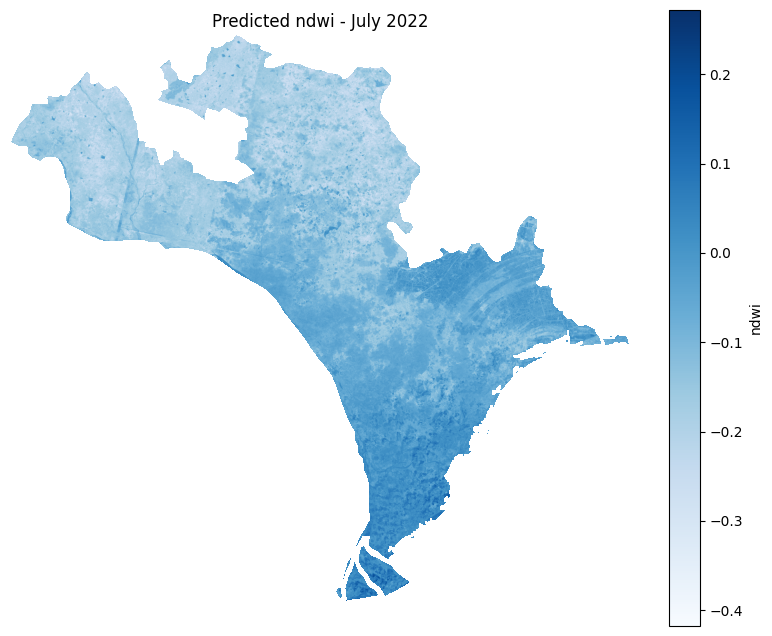

In [9]:
# STEP 6: Save prediction as GeoTIFF
print("Saving prediction to GeoTIFF...")#
# Use last image as template

#July 2022
with rasterio.open(os.path.join(folder, files[-1])) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=1)
    with rasterio.open("..\\BTP\\Results\\Results_July_2022\\predicted_ndwi_July_2022_normalized.tif", "w", **profile) as dst:
        dst.write(predicted.astype(np.float32), 1)
print("✅ Prediction saved as: predicted_July_2022_normalized.tif")

#Jan 2023
# with rasterio.open(os.path.join(folder, files[-1])) as src:
#     profile = src.profile
#     profile.update(dtype=rasterio.float32, count=1)
#     with rasterio.open("..\\BTP\\Results\\Results_Jan_2023\\predicted_ndwi_Jan_2023_normalized.tif", "w", **profile) as dst:
#         dst.write(predicted.astype(np.float32), 1)
# print("✅ Prediction saved as: predicted_Jan_2023_normalized.tif")

#July 2023
# with rasterio.open(os.path.join(folder, files[-1])) as src:
#     profile = src.profile
#     profile.update(dtype=rasterio.float32, count=1)
#     with rasterio.open("..\\BTP\\Results\\Results_July_2023\\predicted_ndwi_July_2023_normalized.tif", "w", **profile) as dst:
#         dst.write(predicted.astype(np.float32), 1)
# print("✅ Prediction saved as: predicted_July_2023_normalized.tif")

#Jan 2024
# with rasterio.open(os.path.join(folder, files[-1])) as src:
#     profile = src.profile
#     profile.update(dtype=rasterio.float32, count=1)
#     with rasterio.open("..\\BTP\\Results\\Results_Jan_2023\\predicted_ndwi_Jan_2023_normalized.tif", "w", **profile) as dst:
#         dst.write(predicted.astype(np.float32), 1)
# print("✅ Prediction saved as: predicted_Jan_2023_normalized.tif")

#July 2024
# with rasterio.open(os.path.join(folder, files[-1])) as src:
#     profile = src.profile
#     profile.update(dtype=rasterio.float32, count=1)
#     with rasterio.open("..\\BTP\\Results\\Results_July_2024\\predicted_ndwi_July_2024_normalized.tif", "w", **profile) as dst:
#         dst.write(predicted.astype(np.float32), 1)
# print("✅ Prediction saved as: predicted_July_2024_normalized.tif")

#Jan 2025
# with rasterio.open(os.path.join(folder, files[-1])) as src:
#     profile = src.profile
#     profile.update(dtype=rasterio.float32, count=1)
#     with rasterio.open("..\\BTP\\Results\\Results_Jan_2025\\predicted_ndwi_Jan_2025_normalized.tif", "w", **profile) as dst:
#         dst.write(predicted.astype(np.float32), 1)
# print("✅ Prediction saved as: predicted_Jan_2025_normalized.tif")



# STEP 7: Preview the prediction

#July 2022
plt.figure(figsize=(10, 8))
plt.imshow(predicted, cmap='Blues')
plt.colorbar(label='ndwi')
plt.title("Predicted ndwi - July 2022")
plt.axis('off')
plt.savefig("..\\BTP\\Results\\Results_July_2022\\predicted_ndwi_July_2022.png", dpi=300)
plt.show()

#Jan 2023
# plt.figure(figsize=(10, 8))
# plt.imshow(predicted, cmap='Blues')
# plt.colorbar(label='ndwi')
# plt.title("Predicted ndwi - Jan 2023")
# plt.axis('off')
# plt.savefig("..\\BTP\\Results\\Results_Jan_2023\\predicted_ndwi_Jan_2023.png", dpi=300)
# plt.show()

#July 2023
# plt.figure(figsize=(10, 8))
# plt.imshow(predicted, cmap='Blues')
# plt.colorbar(label='ndwi')
# plt.title("Predicted ndwi - July 2023")
# plt.axis('off')
# plt.savefig("..\\BTP\\Results\\Results_July_2023\\predicted_ndwi_July_2023.png", dpi=300)
# plt.show()

#Jan 2024
# plt.figure(figsize=(10, 8))
# plt.imshow(predicted, cmap='Blues')
# plt.colorbar(label='ndwi')
# plt.title("Predicted ndwi - Jan 2024")
# plt.axis('off')
# plt.savefig("..\\BTP\\Results\\Results_Jan_2024\\predicted_ndwi_Jan_2024.png", dpi=300)
# plt.show()

#July 2024
# plt.figure(figsize=(10, 8))
# plt.imshow(predicted, cmap='Blues')
# plt.colorbar(label='ndwi')
# plt.title("Predicted ndwi - July 2024")
# plt.axis('off')
# plt.savefig("..\\BTP\\Results\\Results_July_2024\\predicted_ndwi_July_2024.png", dpi=300)
# plt.show()

#Jan 2025
# plt.figure(figsize=(10, 8))
# plt.imshow(predicted, cmap='Blues')
# plt.colorbar(label='ndwi')
# plt.title("Predicted ndwi - Jan 2025")
# plt.axis('off')
# plt.savefig("..\\BTP\\Results\\Results_Jan_2025\\predicted_ndwi_Jan_2025.png", dpi=300)
# plt.show()